# Сессионное задание: Диффузионные модели

**План задания** (суммарно **50 баллов**)

1. **2D-датасет SwissRoll** (суммарно **40 баллов**)
    1. Реализовать прямой и обратный процессы диффузии и обучить базовый DDPM. (20 баллов)
    2. Реализовать classifier-free guidance. (10 баллов)
    3. Реализовать ускоренный семплинг. (10 баллов)

2. **Датасет MNIST** (суммарно **10 баллов**)
    1. Визуализировать прямой диффузионный процесс. (1 балл)
    2. Обучить диффузионную модель с визуально хорошим качеством генерации. (7 баллов)
    3. Сравнить генерации с помощью classifier-free guidance для разных значений guidance scale. (2 балла)

Ваша задача — заполнить пропуски внутри блоков с подписью `ваш код`.


Если вы работаете в `Google Colab`, нужно, чтобы Python «видел» дополнительный файл `utils.py`, который приложен к заданию:

1. Загрузите файл `utils.py` на ваш Google Drive.
2. Раскомментируйте код ниже.
3. Укажите в переменной `path` путь к файлу `utils.py` на вашем Google Drive.


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = "drive/MyDrive/Teaching/2025-generative-model-miphi/Домашки/3_diffusion/utils.py"
# !cp $path .

In [2]:
import os
import re
import random

import numpy as np
import seaborn as sns
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

from utils import get_labeled_data_loader, MyUNet

## DDPM

В этой части мы реализуем свою собственную модель (DDPM) и применим её на датасете SwissRoll.

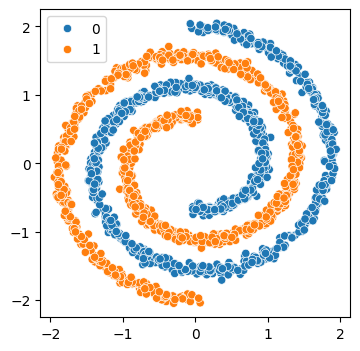

In [3]:
def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y

X, y = make_swiss_dataset(2000)
y = y.astype(int)

plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

**Кратко повторим теорию диффузионных моделей.**

Диффузионная модель состоит из прямого и обратного процессов.

Прямой процесс задаётся условным распределением $q(x_{1:T} \mid x_0)$.

Это марковская цепь, которая последовательно добавляет гауссовский шум к исходному объекту $x_0$.

На каждом шаге добавляется шум некоторой величины, которая определяется расписанием дисперсий $\{\beta_1, \ldots, \beta_T\}$.

Если это расписание выбрано правильно и $T$ стремится к бесконечности (или достаточно велико), процесс сходится к стандартному гауссовскому распределению $\mathcal{N}(0, I)$.

Распределения $q$ имеют следующий вид:
$$
 q(x_t \mid x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}\,x_{t - 1}, \beta_t I),
 \qquad
 q(x_{1:T}\mid x_0) = \prod_{t = 1}^T q(x_t \mid x_{t - 1}).
$$

Теперь рассмотрим обратный процесс.

Обратный процесс последовательно удаляет шум, начиная с чистого гауссовского шума, до тех пор, пока не будет получен объект из исходного распределения.

Таким образом, диффузионная модель является вероятностной моделью с латентными переменными
$p_\theta(x_0) := \int p_\theta(x_{0:T}) \, dx_{1:T}$,
где латентные переменные $x_1, \ldots, x_T$ соответствуют зашумлённым объектам, а $x_0$ — объекту из исходного распределения.

Совместное распределение $p_\theta(x_{0:T})$ определяет обратный процесс диффузии и по сути представляет собой марковскую цепь гауссовых распределений $p_\theta(x_{t-1}\mid x_t)$:

$$
p_\theta(x_{0:T}) = p_\theta(x_T)\,\prod_{t = 1}^T p_\theta(x_{t-1}\mid x_t),
\qquad
p_\theta(x_T) = \mathcal{N}(x_T \mid 0, I),
$$
$$
p_{\theta}(x_{t - 1}\mid x_t) := \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t)).
$$

Вернёмся к распределению $q(x_t \mid x_{t - 1})$.

Чтобы получить $x_t$, нам нужно итеративно вычислить $x_1, \ldots, x_{t - 1}$.

Однако благодаря свойствам гауссовского распределения это можно сделать более эффективно.

Обозначим
$\alpha_t := 1 - \beta_t$ и $\bar{\alpha}_t := \prod_{i = 1}^t \alpha_i$.

Тогда
$$
q(x_t \mid x_0) = \mathcal{N}\bigl(x_t;\sqrt{\bar{\alpha}_t}\,x_0, (1-\bar{\alpha}_t)I\bigr). \qquad (1)
$$

В результате модель может быть обучена путём оптимизации отдельных членов суммы вариационной нижней границы:
$$
L_{VLB} = \mathbb{E}_q \Big[
\underbrace{D_\text{KL}(q(\mathbf{x}_T \mid \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T}
+ \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))}_{L_{t-1}}
\underbrace{- \log p_\theta(\mathbf{x}_0 \mid \mathbf{x}_1)}_{L_0}
\Big].
$$

Для обучения необходимо выписать следующее распределение
$q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I})$:

$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) =
\frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}\,\mathbf{x}_t
+ \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}\,\mathbf{x}_0
\qquad (2)
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t. \qquad (3)
$$

Подробности можно найти в работе [Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239).

В этой статье было показано, что при обучении с более простой функцией потерь достигаются лучшие результаты.

Вспомним, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I). \qquad (4)
$$

Пусть наша модель предсказывает $\epsilon$ из приведённого выше выражения, обучаясь путём оптимизации следующей функции потерь:
$$
L^{\text{simple}}_t = \mathbb{E}_{x_0, \epsilon, t}\big[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2 \big].
$$

В этом задании будет использоваться именно эта функция потерь.

Для выполнения семплинга (обратного процесса) нам необходимо получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$.

Для этого найдите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в уравнение (2).

_____

In [4]:
# Это вспомогательная функция, которая понадобится вам в этом задании.
# Например, когда вы захотите по батчу временных меток брать из предвычисленного массива
# соответствующие коэффициенты прямого диффузионного процесса.

def _extract_into_tensor(arr: th.Tensor, timesteps: th.Tensor, broadcast_shape: Tuple):
    """
    Вытаскивает значения из одномерного тензора по батчу индексов.

    Параметры:
    - arr: одномерный тензор.
    - timesteps: батч индексов, по которым хотим извлечь значения из тензора.
    - broadcast_shape: shape с K размерностями, к которому нужно привести итоговый тензор.

    Возвращает: тензор с shape [batch_size, 1, ...], где shape имеет K размерностей.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [5]:
# Функция, которая возвращает список «рабочих» коэффициентов betas для диффузионного процесса
# в зависимости от длины марковской цепочки.

def get_beta_schedule(num_diffusion_timesteps: int) -> th.Tensor:
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    betas = th.from_numpy(betas).double()
    return betas

In [6]:
# Класс BaseDiffusion принимает на вход коэффициенты betas, которые задают и прямой, и обратный процессы.
# Также в этом классе мы предварительно вычисляем величины, которые пригодятся нам позднее.

class BaseDiffusion:
    def __init__(self, betas: th.Tensor) -> None:
        self.betas = betas
        self.alphas = 1 - self.betas
        self.alphas_cumprod = th.cumprod(self.alphas, dim=-1)
        self.num_timesteps = len(self.betas)

basediff = BaseDiffusion(get_beta_schedule(20))
basediff.alphas_cumprod

tensor([9.9500e-01, 9.3792e-01, 8.3499e-01, 6.9964e-01, 5.4958e-01, 4.0293e-01,
        2.7431e-01, 1.7238e-01, 9.9302e-02, 5.2003e-02, 2.4510e-02, 1.0268e-02,
        3.7641e-03, 1.1827e-03, 3.0969e-04, 6.4872e-05, 1.0192e-05, 1.0674e-06,
        5.5900e-08, 0.0000e+00], dtype=torch.float64)

### Реализуйте прямой процесс диффузии

Общая идея

Прямой процесс диффузии — это поэтапное добавление гауссовского шума к исходным данным.
С каждым шагом данные становятся всё более зашумлёнными, пока не превращаются почти в чистый шум.

Интуитивная интерпретация
Каждый шаг «стирает» часть информации из данных.
alphas_cumprod показывает, сколько информации осталось.

In [7]:
class ForwardDiffusion(BaseDiffusion):
    def q_mean_variance(self, x0: th.Tensor, t: th.Tensor):
        alpha_bar_t = _extract_into_tensor(
            self.alphas_cumprod, t, x0.shape
        )
        mean = alpha_bar_t.sqrt() * x0
        variance = 1.0 - alpha_bar_t
        return mean, variance

    def q_sample(self, x0: th.Tensor, t: th.Tensor, noise: Optional[th.Tensor] = None):
        if noise is None:
            noise = th.randn_like(x0)

        mean, var = self.q_mean_variance(x0, t)
        return mean + var.sqrt() * noise

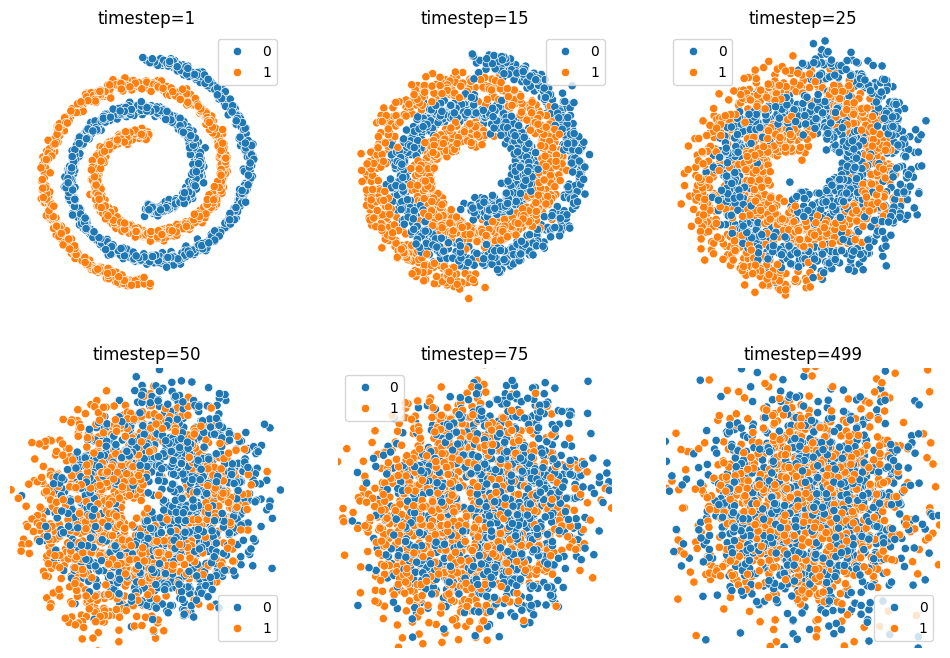

In [8]:
# Посмотрим на прямой процесс диффузии, применённый к SwissRoll

T = 500
forward_diffusion = ForwardDiffusion(get_beta_schedule(T))

timesteps_to_plot = [1, 15, 25, 50, 75, 499]
n_plots = len(timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        X_noised = forward_diffusion.q_sample(
            x0=th.from_numpy(X),
            t=th.ones_like(th.from_numpy(y)).long() * timesteps_to_plot[idx],
        )
        sns.scatterplot(x=X_noised[:, 0], y=X_noised[:, 1], hue=y, ax=axes[i, j])
        axes[i, j].set_title(f"timestep={timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

### Реализуйте обратный процесс диффузии

Интуиция
Прямой процесс: x0 → xT (добавление шума шаг за шагом)
Обратный процесс: xT → x0 (постепенное «очищение» шума)
Класс ReverseDiffusion реализует именно эту логику, используя аналитические коэффициенты для среднего и дисперсии, что позволяет эффективно сэмплировать изображения из шума.

In [10]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # ᾱ_{t-1}
        self.alphas_cumprod_prev = th.cat(
            [th.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]],
            dim=0
        )

        # (3) Var[q(x_{t-1} | x_t, x_0)]
        self.variance = (
            (1.0 - self.alphas_cumprod_prev)
            / (1.0 - self.alphas_cumprod)
            * self.betas
        )

        # (2) коэффициенты среднего
        self.xt_coef = (
            self.alphas.sqrt()
            * (1.0 - self.alphas_cumprod_prev)
            / (1.0 - self.alphas_cumprod)
        )

        self.x0_coef = (
            self.alphas_cumprod_prev.sqrt()
            * self.betas
            / (1.0 - self.alphas_cumprod)
        )

    def get_x0(self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor) -> th.Tensor:
        # (4) восстановление x0 из xt и eps
        alpha_bar_t = _extract_into_tensor(
            self.alphas_cumprod, t, xt.shape
        )
        x0 = (xt - (1.0 - alpha_bar_t).sqrt() * eps) / alpha_bar_t.sqrt()
        return x0

    def q_posterior_mean_variance(
        self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor
    ) -> Tuple[th.Tensor, th.Tensor]:
        # восстановим x0
        x0 = self.get_x0(xt, eps, t)

        # (2) среднее
        xt_coef = _extract_into_tensor(self.xt_coef, t, xt.shape)
        x0_coef = _extract_into_tensor(self.x0_coef, t, xt.shape)
        mean = xt_coef * xt + x0_coef * x0

        # (3) дисперсия
        variance = _extract_into_tensor(self.variance, t, xt.shape)

        return mean, variance

    def p_sample(self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor) -> th.Tensor:
        mean, variance = self.q_posterior_mean_variance(xt=xt, eps=eps, t=t)
        noise = th.randn_like(xt, device=xt.device)

        nonzero_mask = th.ones_like(t)
        nonzero_mask[t == 0] = 0
        nonzero_mask = _extract_into_tensor(
            nonzero_mask, th.arange(nonzero_mask.shape[0]), xt.shape
        ).to(xt.device)

        sample = mean + nonzero_mask * variance.sqrt() * noise
        return sample.float()


### Реализуем архитектуру нейронной сети для предсказания шума

In [11]:
# Заметьте, что модель на вход принимает не только зашумлённый объект,
# но также момент времени и индекс класса.

class ConditionalMLP(nn.Module):
    def __init__(self, d_in: int, T: int, n_classes: int, hidden_dim: Optional[int]=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(d_in, self.hidden_dim)
        self.t_proj = nn.Embedding(T, self.hidden_dim)
        self.y_embed = nn.Embedding(n_classes, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, 2 * self.hidden_dim),
            nn.GELU(),
            nn.Linear(2 * self.hidden_dim, d_in)
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t, y):
        """
        Параметры:
        - x: зашумлённая картинка.
        - t: счётчик времени/уровень шума.
        - y: индекс класса, который нужно сгенерировать.
        """
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        y = self.y_embed(y)
        x = x + t + y
        x = F.gelu(x)
        return self.backbone(x)

### Реализуйте DDPM

In [12]:
class DDPM(nn.Module):
    def __init__(
        self,
        betas: th.Tensor,
        model: nn.Module,
        shape: Optional[th.Tensor] = None,
    ) -> None:
        super().__init__()

        self.forward_diffusion = ForwardDiffusion(betas=betas)
        self.reverse_diffusion = ReverseDiffusion(betas=betas)
        self.model = model
        self.num_timesteps = len(betas)

        self.register_buffer("betas", betas)
        self.register_buffer("shape", shape)

    @property
    def device(self) -> None:
        return next(self.parameters()).device

    @th.no_grad()
    def sample(self, y: th.Tensor) -> th.Tensor:
        num_samples = y.shape[0]
        x = th.randn((num_samples, *self.shape), device=self.device, dtype=th.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = th.tensor([i] * num_samples, device=x.device)

            # 1) предсказываем шум ε_θ(x_t, t, y)
            eps = self.model(x, t, y)

            # 2) шаг разшумления
            x = self.reverse_diffusion.p_sample(x, eps, t)

        return x, y

    def train_loss(self, x0: th.Tensor, y: th.Tensor) -> th.Tensor:
        if self.shape is None:
            self.shape = th.tensor(list(x0.shape)[1:], device="cpu")

        # случайный timestep
        t = th.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)

        # шум ε
        noise = th.randn_like(x0)

        # 1) зашумляем x0 → x_t
        xt = self.forward_diffusion.q_sample(x0, t, noise)

        # 2) предсказываем шум по x_t
        eps = self.model(xt, t, y)

        loss = F.mse_loss(eps, noise)
        return loss


In [13]:
# Теперь давайте обучим наш DDPM.

def train_model(
    ddpm: DDPM,
    dataloader: DataLoader,
    *,
    lr: float,
    n_iters: int,
    device: str = "cpu",
    log_every: int = 500
):
    ddpm.to(device)

    optimizer = th.optim.Adam(ddpm.model.parameters(), lr=lr)

    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < n_iters:
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)

        x, y = batch["x"].to(device), batch["y"].to(device)

        loss = ddpm.train_loss(x, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{n_iters} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0

        step += 1

In [14]:
T = 500
BATCH_SIZE = 1024
LR = 0.01
N_ITERS = 10000

model = ConditionalMLP(d_in=2, T=T, n_classes=2)
device = "cpu" # можно считать на гпу, но цпу должно быть достаточно

ddpm = DDPM(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(X, y, batch_size=BATCH_SIZE, shuffle=True)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

Step 500/10000 Loss: 0.29
Step 1000/10000 Loss: 0.2639
Step 1500/10000 Loss: 0.2606
Step 2000/10000 Loss: 0.2563
Step 2500/10000 Loss: 0.2541
Step 3000/10000 Loss: 0.2481
Step 3500/10000 Loss: 0.245
Step 4000/10000 Loss: 0.2437
Step 4500/10000 Loss: 0.2408
Step 5000/10000 Loss: 0.2415
Step 5500/10000 Loss: 0.24
Step 6000/10000 Loss: 0.2399
Step 6500/10000 Loss: 0.2394
Step 7000/10000 Loss: 0.2378
Step 7500/10000 Loss: 0.2377
Step 8000/10000 Loss: 0.2387
Step 8500/10000 Loss: 0.2373
Step 9000/10000 Loss: 0.2354
Step 9500/10000 Loss: 0.2365
Step 10000/10000 Loss: 0.2352


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.11it/s]


Text(0.5, 1.0, 'real')

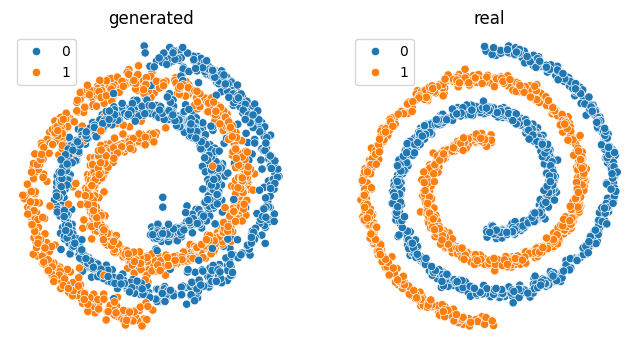

In [15]:
# Теперь давайте посмотрим, что наша модель научилась генерировать (должно быть похоже на наш SwissRoll датасет)

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)
Xs, ys = ddpm.sample(ys)

_, (ax_gen, ax_real) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.scatterplot(x=Xs[:, 0].cpu().numpy(), y=Xs[:, 1].cpu().numpy(), hue=ys.cpu().numpy(), ax=ax_gen); ax_gen.set_axis_off();
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax_real); ax_real.set_axis_off();

ax_gen.set_title("generated")
ax_real.set_title("real")

FID

In [20]:
def calculate_fid(X_real, X_gen):
    import numpy as np
    from scipy.linalg import sqrtm
    import torch

    # Преобразуем PyTorch тензоры в numpy
    if isinstance(X_real, torch.Tensor):
        X_real = X_real.cpu().numpy()
    if isinstance(X_gen, torch.Tensor):
        X_gen = X_gen.cpu().numpy()
    
    mu_real = np.mean(X_real, axis=0)
    mu_gen = np.mean(X_gen, axis=0)
    sigma_real = np.cov(X_real, rowvar=False)
    sigma_gen = np.cov(X_gen, rowvar=False)
    
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid = np.sum((mu_real - mu_gen)**2) + np.trace(sigma_real + sigma_gen - 2*covmean)
    return fid

fid_score = calculate_fid(X, Xs)
print("FID score:", fid_score)


FID score: 0.0006722220833098762


## Classifier-free guidance

К этому моменту мы реализовали базовый алгоритм для диффузионных моделей DDPM.

Теперь реализуем **classifier-free guidance** — технику для улучшения class-conditional генерации, которую мы разбирали на лекции.

Итоговая формула очень простая:
$$
\hat{\epsilon}_\theta(x_t, t, y) =
\epsilon_\theta(x_t, t, y=\varnothing)
+ s\bigl(\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, y=\varnothing)\bigr), \qquad (1)
$$
где:
- $\epsilon_\theta(x_t, t, y)$ — модель, которую мы обучаем;
- $s$ — guidance scale (контролирует силу guidance);
- $\hat{\epsilon}_\theta(x_t, t, y)$ — итоговая модель для предсказания шума;
- $y$ — класс, который мы хотим сгенерировать;
- $y = \varnothing$ означает, что в нейронную сеть подаётся специальный «пустой» класс для unconditional-режима.

**Обучение** происходит следующим образом:

1. Семплируем
   $$
   (x_0, c) \sim p_{\text{data}}, \quad
   t \sim \text{Uniform}\{1, \ldots, T\}, \quad
   \epsilon \sim \mathcal{N}(0, I).
   $$
2. Зашумляем данные:
   $$
   x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1 - \bar{\alpha}_t}\,\epsilon.
   $$
3. С вероятностью $p$ выбираем, учим ли мы модель в unconditional- или conditional-режиме:
   - unconditional:
     $$
     \|\epsilon_\theta(x_t, t, y=\varnothing) - \epsilon\|_2^2,
     $$
   - conditional:
     $$
     \|\epsilon_\theta(x_t, t, y=c) - \epsilon\|_2^2.
     $$

*Замечание.* Логика выбора unconditional-/conditional-режима обучения реализована за вас в классе `LabeledDataset` (лежит в `utils.py`). Это сделано затем, чтобы можно было переиспользовать функцию `train_model` без изменений. Обратите внимание на параметр `drop_label`.


### Реализуйте Classifier-free Guidance

# Параметры и атрибуты DDPM / DDPMWithCFG

| Название | Тип | Где используется | Описание / Значение |
|----------|-----|-----------------|-------------------|
| `betas` | `torch.Tensor` | конструктор | Вектор β-шагов диффузии длины `T`. Определяет дисперсию шума на каждом шаге прямого процесса. |
| `model` | `nn.Module` | конструктор | Нейросеть εθ для предсказания шума. Входы: `x_t`, `t`, `y`. |
| `shape` | `tuple` / `torch.Tensor` | конструктор / атрибут | Форма объектов, например `[2]` для SwissRoll, `[1,28,28]` для MNIST. |
| `num_timesteps` | `int` | конструктор / атрибут | Длина диффузионной цепочки T. |
| `forward_diffusion` | `ForwardDiffusion` | атрибут | Прямой процесс q(x_t | x_0), добавление шума. |
| `reverse_diffusion` | `ReverseDiffusion` | атрибут | Обратный процесс pθ(x_{t-1} | x_t), удаление шума. |
| `train_loss(x0, y)` | метод | обучающий | Функция потерь MSE между предсказанным и реальным шумом. |
| `sample(y)` | метод | генерация | Генерация с помощью обученной модели (conditional). |
| `sample_with_cfg(y, guidance_scale, null_label)` | метод (DDPMWithCFG) | генерация | Генерация с classifier-free guidance. `guidance_scale=0` → unconditional, `=1` → обычное conditional, >1 → усиливаем влияние класса. |
| `null_label` | `int` | метод sample_with_cfg | Индекс класса для unconditional режима. |
| `_predict_eps_hat(x, t, y, guidance_scale, null_label)` | метод | внутренний | Вычисляет ε̂ для CFG: ε_uncond + s*(ε_cond - ε_uncond). |

### 🔹 Основное

- **Обучаемые параметры**: только у `model` (нейросеть εθ).  
- **Все остальные атрибуты**: фиксированные коэффициенты или вспомогательные объекты для прямого/обратного процесса.  
- `DDPMWithCFG` не добавляет новых обучаемых параметров, а лишь реализует CFG при генерации.


In [21]:
class DDPMWithCFG(DDPM):
    @th.no_grad()
    def sample_with_cfg(
        self,
        y: th.Tensor,
        guidance_scale: float = 0.0,
        null_label: int = 2,
    ):
        """
        Параметры:
        - y: метка класса;
        - guidance_scale:
            - 0: unconditional-режим;
            - 1: conditional-режим, честно восстанавливающий распределение;
            - чем выше значение, тем сильнее влияние класса;
        - null_label: заранее подготовленный индекс класса, отвечающий за unconditional-обучение.
        """
        assert self.shape is not None

        num_samples = y.shape[0]
        x = th.randn((num_samples, *self.shape), device=self.device, dtype=th.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = th.tensor([i] * num_samples, device=x.device)

            # 1) предсказываем ε̂ с CFG
            eps_hat = self._predict_eps_hat(
                x=x,
                t=t,
                y=y,
                guidance_scale=guidance_scale,
                null_label=null_label,
            )

            # 2) шаг разшумления
            x = self.reverse_diffusion.p_sample(x, eps_hat, t)

        return x, y

    def _predict_eps_hat(
        self,
        x: th.Tensor,
        t: th.Tensor,
        y: th.Tensor,
        guidance_scale: float,
        null_label: int,
    ):
        # unconditional метки
        null_y = null_label * th.ones_like(y)

        # ε_uncond
        eps_uncond = self.model(x, t, null_y)

        # ε_cond
        eps_cond = self.model(x, t, y)

        # (1) classifier-free guidance
        eps_hat = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        return eps_hat


In [22]:
T = 500
BATCH_SIZE = 1024
LR = 0.0025
N_ITERS = 30000
DROP_LABEL = 0.4

model = ConditionalMLP(d_in=2, T=T, n_classes=2+1)
device = "cpu" # можно считать на гпу, но цпу должно быть достаточно

ddpm = DDPMWithCFG(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(X, y, batch_size=BATCH_SIZE, shuffle=True, drop_label=DROP_LABEL)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

Step 500/30000 Loss: 0.3037
Step 1000/30000 Loss: 0.268
Step 1500/30000 Loss: 0.2647
Step 2000/30000 Loss: 0.262
Step 2500/30000 Loss: 0.2624
Step 3000/30000 Loss: 0.2623
Step 3500/30000 Loss: 0.2605
Step 4000/30000 Loss: 0.2598
Step 4500/30000 Loss: 0.2573
Step 5000/30000 Loss: 0.2561
Step 5500/30000 Loss: 0.2538
Step 6000/30000 Loss: 0.252
Step 6500/30000 Loss: 0.251
Step 7000/30000 Loss: 0.2521
Step 7500/30000 Loss: 0.2504
Step 8000/30000 Loss: 0.251
Step 8500/30000 Loss: 0.2504
Step 9000/30000 Loss: 0.2494
Step 9500/30000 Loss: 0.2486
Step 10000/30000 Loss: 0.249
Step 10500/30000 Loss: 0.2489
Step 11000/30000 Loss: 0.2479
Step 11500/30000 Loss: 0.2487
Step 12000/30000 Loss: 0.246
Step 12500/30000 Loss: 0.2488
Step 13000/30000 Loss: 0.2477
Step 13500/30000 Loss: 0.2468
Step 14000/30000 Loss: 0.2462
Step 14500/30000 Loss: 0.2477
Step 15000/30000 Loss: 0.2456
Step 15500/30000 Loss: 0.2451
Step 16000/30000 Loss: 0.2469
Step 16500/30000 Loss: 0.2467
Step 17000/30000 Loss: 0.2459
Step 17



# Анализ качества генерации с разным `guidance_scale`

## 1. Цель кода

Код предназначен для **визуальной оценки качества генерации** модели диффузии (DDPM) при различном **guidance scale**.

* **Guidance scale** — коэффициент управления генерацией условием (классом).
* Он регулирует, насколько сильно модель следует условию при генерации:

  * Малые значения → слабое следование условию.
  * Большие значения → сильное следование условию, но возможны искажения.

---

## 2. Что делает код

1. **Задаются параметры для визуализации**:

   * `guidance_scale_to_plot = [1.0, 2.0, 3.0, 4.0, 16.0]`
   * `n_plots` — количество графиков (один для реальных данных и несколько для разных guidance scale).

2. **Создаётся сетка графиков** (`matplotlib`).

3. **Первая панель**:

   * Отображает **реальные данные** `X` для сравнения с генерацией.
   * Цвет точек соответствует классу `y`.

4. **Остальные панели**:

   * Генерируются с помощью DDPM с разными `guidance_scale`.
   * Используется метод `sample_with_cfg`, который возвращает:

     * `Xs` — сгенерированные данные,
     * `ys` — классы (условия).
   * Цвет точек показывает соответствие классу.

5. **Визуальные настройки**:

   * Ограничение осей для удобного сравнения: `[-2.5, 2.5]`
   * Отключение осей для чистого отображения графиков.

---

## 3. Как оценивать результаты

При оценке генерации с разным guidance scale обращают внимание на три аспекта:

### 3.1 Сходство с реальными данными

* Как распределение точек `Xs` соотносится с реальными точками `X`?
* Структура, плотность, форма кластеров.

### 3.2 Четкость и разделение классов

* При низком guidance scale:

  * Классы могут **сливаться** (точки разных цветов смешаны).
* При высоком guidance scale:

  * Классы **чётко разделены**, но иногда структура может искажаться.

### 3.3 Аномальные эффекты при больших значениях

* Очень высокий guidance scale (например, 16) может привести к:

  * Артефактам в распределении точек
  * Неестественной структуре
* Оптимальный guidance scale — **сбалансированная точность по условию и сохранение структуры данных**.

---

## 4. Выводы

* **Guidance scale = 1–4** обычно хорошо сохраняет структуру и классы.
* **Guidance scale слишком высокий** → модели трудно следовать условию без искажения.
* Визуальный анализ помогает **подобрать оптимальное значение guidance scale** для генерации качественных данных.


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 154.88it/s]


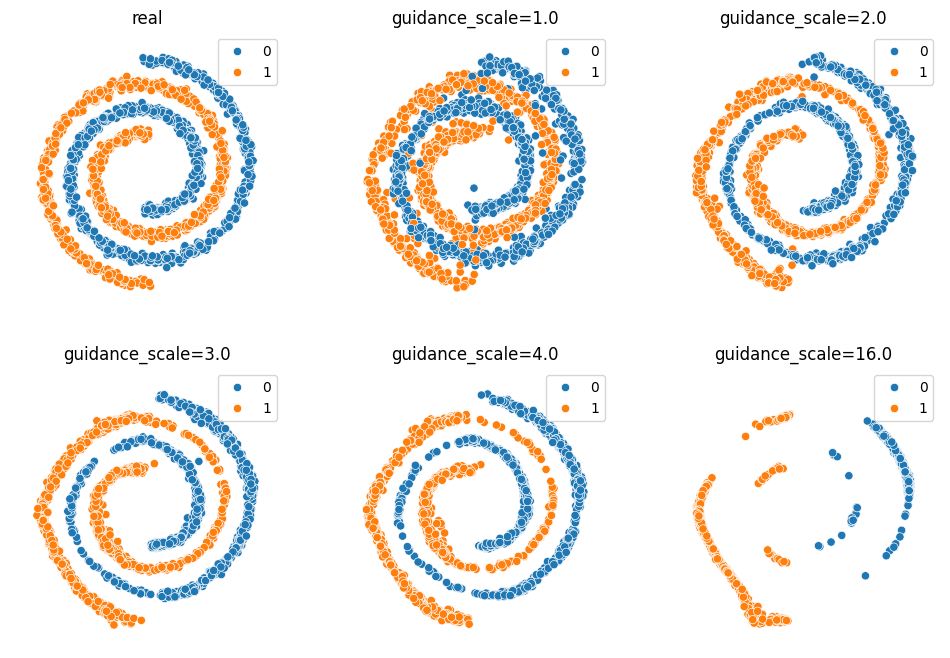

In [23]:
# Давайте посмотрим на качество генерации c разным guidance scale

guidance_scale_to_plot = [1.0, 2.0, 3.0, 4.0, 16.0]
n_plots = len(guidance_scale_to_plot) + 1
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        if idx == 0:
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axes[i, j])
            axes[i, j].set_title("real")
        else:
            idx = idx - 1
            Xs, ys = ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale_to_plot[idx], null_label=2)
            sns.scatterplot(x=Xs[:, 0].cpu().numpy(), y=Xs[:, 1].cpu().numpy(), hue=ys.cpu().numpy(), ax=axes[i, j])
            axes[i, j].set_title(f"guidance_scale={guidance_scale_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

# Оценка оптимального `guidance_scale`

На основании визуального анализа графиков генерации с разными значениями `guidance_scale` было отмечено:

* **Guidance scale = 1.0**

  * Точки сгенерированных данных сливаются между классами.
  * Четкость разделения классов невысокая.

* **Guidance scale = 2.0**

  * Классы четко разделены.
  * Распределение точек хорошо повторяет структуру исходных данных.
  * Минимальные артефакты и искажения.

* **Guidance scale = 3.0–4.0**

  * Классы остаются разделенными.
  * Появляются небольшие искажения структуры данных.

* **Guidance scale = 16.0**

  * Чрезмерное усиление условного сигнала.
  * Структура данных нарушается, появляются артефакты.

---

## Вывод

**Наиболее оптимальное значение guidance scale для данной задачи визуально определяется как `2.0`**, так как оно обеспечивает баланс между:

1. Четким разделением классов
2. Сохранением структуры исходных данных
3. Минимизацией артефактов при генерации


**Замечания про classifier-free guidance:**
- генерирует семплы, которые более вероятны для конкретного класса (чем выше guidance scale, тем меньше пересечения между генерациями разных классов);
- слишком большой guidance scale может приводить к выбросам

## Ускоренный семплинг из DDPM

На данном этапе мы реализовали DDPM и технику classifier-free guidance.
В текущей реализации для генерации нужно делать столько же шагов, сколько вершин в марковской цепочке, а в случае использования classifier-free guidance — в два раза больше.
Это не критично для нашего игрушечного датасета SwissRoll, однако чем сложнее датасет и больше размерность данных, тем дороже становится каждый шаг генерации.

В этой части мы реализуем математически обоснованный способ пропускать некоторые вершины марковской цепочки для более быстрого семплинга из DDPM. Этот подход мы также обсуждали на лекции.

Вкратце вспомним, что там происходило.

Пусть у нас есть DDPM с максимальным индексом вершины в марковской цепочке $T$, и мы хотим семплировать за $I < T$ шагов.
При этом важно, чтобы мы могли переиспользовать предобученную на $T$ шагах диффузионную модель $\epsilon_\theta(x_t, t)$, где $t \in \{1, \ldots, T\}$.

Для этого мы искали более короткую марковскую цепочку длины $I$ (вершины будут проиндексированы $i \in \{1, \ldots, I\}$), которая является подцепочкой исходной более длинной:

1. Мы выбрали, каким вершинам исходной длинной цепочки будет соответствовать новая цепочка. Для этого мы задали функцию
   $\tau: \{1, \ldots, I\} \to \{1, \ldots, T\}$,
   которая отображает временные индексы новой цепочки в индексы старой. При этом важно, чтобы $\tau(I) = T$, чтобы новая цепочка всё так же заканчивалась в стандартном гауссовском распределении.

2. Далее мы формализовали наше желание, чтобы новая короткая цепочка была подцепочкой исходной. Для этого мы выровняли их соответствующие маргинальные распределения:
   $$
   q_{\text{new}}(x_i) = q(x_{t = \tau(i)}).
   $$

3. Это условие позволило нам найти параметры короткой диффузионной марковской цепочки:
   $$
   \beta_{\text{new}, i} = 1 - \alpha_{\text{new}, i}
   = 1 - \frac{\bar{\alpha}_{\tau(i)}}{\bar{\alpha}_{\tau(i - 1)}}. \qquad (1)
   $$

4. Также это позволило нам переиспользовать предобученную на длинной цепочке диффузионную модель $\epsilon_\theta(x_t, t)$:
   $$
   \epsilon_{\text{new}, \theta}(x_i, i) = \epsilon_\theta(x_t = x_i, t = \tau(i)). \qquad (2)
   $$

Таким образом, нам нужно сделать класс DDPM с правильными параметрами новой, более короткой марковской цепочки, определёнными выше, и корректным переиспользованием предобученной диффузионной модели, чтобы семплировать за $I < T$ шагов.


### Реализуйте WrappedModel и SpacedDDPMWithCFG

In [24]:
class WrappedModel(nn.Module):
    """
    Класс обёртка для предобученной диффузионной модели epsilon(x_t, t),
    которая позволяет учитывать отображение tau счётчиков времени из нового в старый.
    """
    def __init__(self, model: nn.Module, timestep_map: List):
        super().__init__()
        self.model = model
        self.timestep_map = timestep_map

    @property
    def device(self):
        return next(self.model.parameters()).device

    def forward(self, x: th.Tensor, t: th.Tensor, *args, **kwargs) -> th.Tensor:
        # переводим timestep новой (короткой) цепочки
        # в timestep старой (длинной) цепочки
        new_t = th.tensor(
            [self.timestep_map[i] for i in t.tolist()],
            device=t.device,
            dtype=t.dtype,
        )

        return self.model(x, new_t, *args, **kwargs)


In [25]:
class SpacedDDPMWithCFG(DDPMWithCFG):
    """
    Класс для адаптации DDPM для более короткой марковской цепочки.
    Переопределяет параметры betas и использование нейронной сети.
    """

    def __init__(self, use_timesteps: Optional[Tuple] = None, **kwargs):
        # Если use_timesteps не задан, будем ходить по всем вершинам длинной цепочки
        if use_timesteps is None:
            use_timesteps = list(range(len(kwargs["betas"])))
        self.use_timesteps = set(use_timesteps)

        base_ddpm = DDPM(**kwargs)

        last_alpha_cumprod = 1.0
        new_betas = []

        for t, alpha_cumprod in enumerate(base_ddpm.forward_diffusion.alphas_cumprod):
            if t in self.use_timesteps:
                # вычисляем beta для короткой цепочки
                beta = 1.0 - alpha_cumprod / last_alpha_cumprod
                new_betas.append(beta)
                last_alpha_cumprod = alpha_cumprod

        kwargs = deepcopy(kwargs)
        kwargs["betas"] = th.tensor(new_betas, device=base_ddpm.device)
        kwargs["model"] = WrappedModel(kwargs["model"], use_timesteps)

        super().__init__(**kwargs)


In [26]:
# Вспомогательная функция, которая позволяет создать SpacedDDPMWithCFG по инстансу DDPM
# и задать количество шагов, которое мы хотим использовать.
# Эта функция распределяет шаги равномерно по вершинам (это частный случай и может быть неоптимален).

def get_spaced_ddpm(ddpm: DDPMWithCFG, num_timesteps: int=None):
    if num_timesteps is not None:
        num_timesteps = min(num_timesteps, ddpm.num_timesteps)
        use_timesteps = np.linspace(1, ddpm.num_timesteps, num=num_timesteps+1).astype("int")[1:]
    else:
        use_timesteps = None

    return SpacedDDPMWithCFG(
        use_timesteps=use_timesteps,
        betas=ddpm.betas,
        model=ddpm.model,
        shape=ddpm.shape,
    )


# Влияние количества шагов семплирования на качество генерации (guidance_scale = 1)

## 1. Цель кода

Этот блок кода исследует, как **сокращение числа шагов обратного процесса диффузии** (семплирования) влияет на качество сгенерированных данных.

* **Guidance scale** фиксирован на `1.0` для минимального влияния условного сигнала.
* Изменяется **количество шагов семплирования**: 500, 250, 100, 50, 25, 10.
* Чем меньше шагов, тем быстрее генерация, но потенциально хуже качество.

---

## 2. Что делает код

1. **Определяет параметры для визуализации**:

   * `num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]`
   * Создается сетка графиков (`nrows x ncols`) для сравнения.

2. **Генерация данных для каждого количества шагов**:

   * `get_spaced_ddpm(ddpm, num_timesteps)` создаёт новую модель DDPM, которая **использует меньше шагов семплирования**, равномерно распределяя исходные временные шаги.
   * `Xs, ys = spaced_ddpm.sample_with_cfg(...)` генерирует точки и их классы для данного числа шагов.

3. **Визуализация**:

   * Для каждого количества шагов строится scatter plot с цветовой маркировкой классов (`ys`).
   * Ограничение осей: `[-2.5, 2.5]`
   * Отключение осей для чистого отображения графиков.

---

## 3. Как оценивать результаты

При сравнении генерации с разным количеством шагов обращают внимание на:

1. **Сходство с реальными данными**:

   * Распределение точек и форма кластеров.

2. **Четкость классов**:

   * При малом количестве шагов классы могут сливаться или появляться шумные точки.

3. **Артефакты и искажения**:

   * Сильнее проявляются при слишком быстром семплировании (мало шагов).

---

## 4. Интуитивная интерпретация

* **Много шагов (например, 500)** → высокое качество, плавное восстановление исходной структуры.
* **Мало шагов (например, 10–25)** → генерация ускоряется, но появляются искажения и шум, структура данных частично теряется.

---

## 5. Вывод

Этот эксперимент помогает выбрать **оптимальный компромисс между скоростью генерации и качеством**.

* Слишком мало шагов → быстрый, но низкокачественный генератор.
* Оптимальное количество шагов обеспечивает сохранение структуры и четкое разделение классов при разумной скорости.

---

Если хочешь, я могу сделать **табличку или график для отчета**, показывающий, как качество генерации ухудшается с уменьшением числа шагов. Это очень наглядно.


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 93.24it/s]


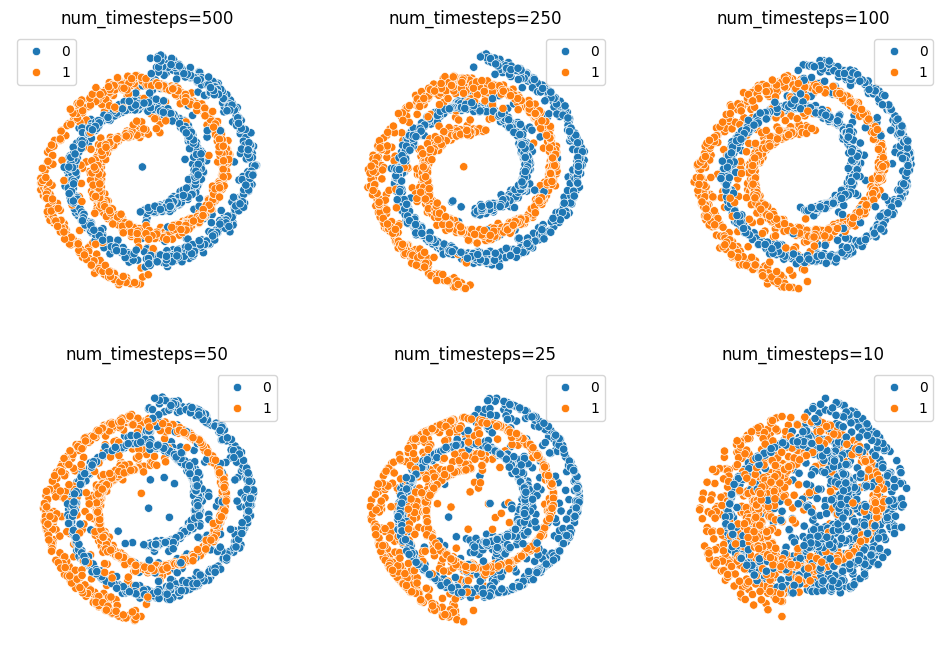

In [28]:
# Давайте посмотрим на качество генерации при уменьшении количества шагов семплирования (guidance_scale = 1).

guidance_scale = 1.

num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]
n_plots = len(num_timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        spaced_ddpm = get_spaced_ddpm(ddpm, num_timesteps_to_plot[idx])
        Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=2)
        sns.scatterplot(x=Xs[:, 0].detach().cpu().numpy(), y=Xs[:, 1].detach().cpu().numpy(), hue=ys.detach().cpu().numpy(), ax=axes[i, j])
        axes[i, j].set_title(f"num_timesteps={num_timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

# Выбор количества шагов семплирования

На основании визуального анализа генерации с разным числом шагов (guidance_scale = 1) было отмечено:

* **500 шагов** — высокое качество, почти идеальное восстановление структуры данных.
* **250 шагов** — структура сохраняется, небольшие отличия от 500 шагов.
* **100 шагов** — качество генерации всё ещё хорошее, кластеры четко разделены, структура данных сохранена.
* **50 шагов и меньше** — заметное ухудшение качества: точки становятся более рассеянными, классы частично сливаются, появляются артефакты.

---

## Вывод

**100 шагов семплирования выглядит достаточным**, так как:

1. Классы четко разделены.
2. Распределение точек хорошо повторяет исходные данные.
3. Генерация существенно ускоряется по сравнению с 500 шагами.

Таким образом, **100 шагов** — оптимальный компромисс между **скоростью и качеством генерации**.


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 96.22it/s]


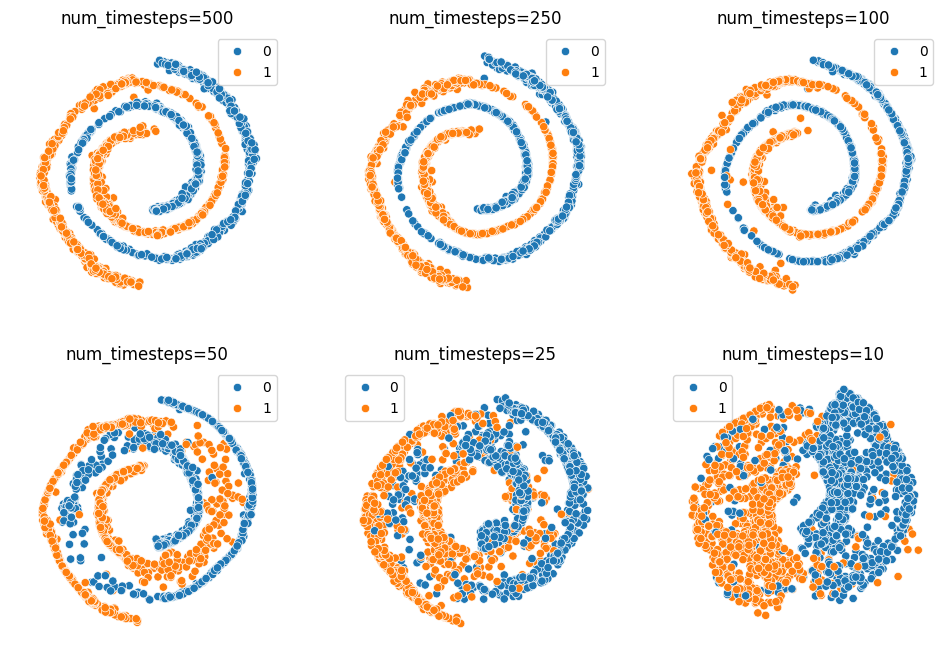

In [30]:
# Давайте посмотрим на качество генерации при уменьшении количества шагов семплирования (guidance_scale = 3).
guidance_scale = 3

num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]
n_plots = len(num_timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        spaced_ddpm = get_spaced_ddpm(ddpm, num_timesteps_to_plot[idx])
        Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=2)
        sns.scatterplot(x=Xs[:, 0].detach().cpu().numpy(), y=Xs[:, 1].detach().cpu().numpy(), hue=ys.detach().cpu().numpy(), ax=axes[i, j])
        axes[i, j].set_title(f"num_timesteps={num_timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

У нас получилось значительно сократить количество шагов генерации без особой потери в качестве!

Unconditional vs Conditional

Unconditional vs Conditional генерация.
В unconditional-режиме (guidance_scale = 0) модель аппроксимирует общее распределение данных без учёта классов — классовая структура отсутствует.
В conditional-режиме (guidance_scale = 1) модель корректно учитывает условие и генерирует данные с чётким разделением классов, сохраняя форму исходного распределения.
Это демонстрирует, что conditioning действительно управляет процессом генерации, а classifier-free guidance позволяет эффективно переключаться между режимами.

Смысл Unconditional генерации:
- Понять, как модель аппроксимирует общее распределение данных, без учета разделения на классы. Это может быть полезно для оценки общего качества работы модели.
- Исследовать, как генеративная модель работает без жесткого контроля над классами или метками. То есть, как она "учится" генерировать данные вообще, без применения конкретных ограничений.

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 139.17it/s]


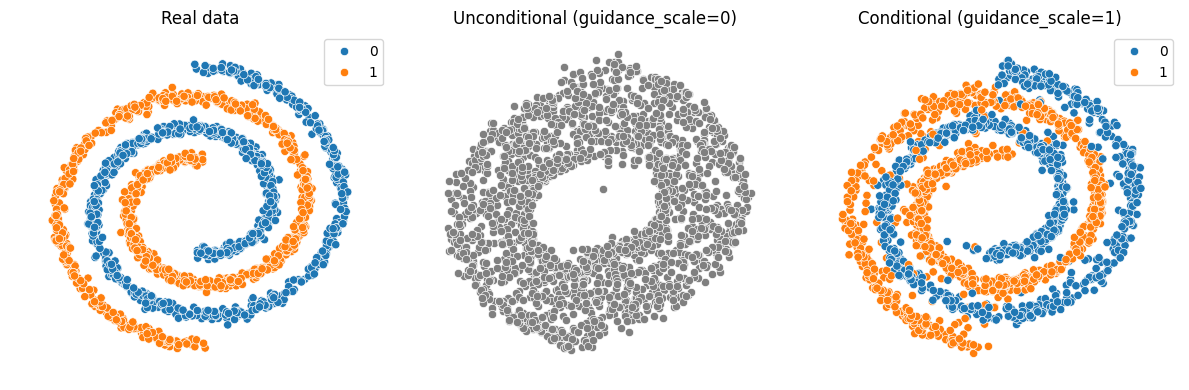

In [31]:
# ============================
# Unconditional vs Conditional
# ============================

num_samples = X.shape[0]

# фиксируем случайные метки классов
ys = th.randint(0, 2, size=(num_samples,), device=device)

# ---------- Unconditional ----------
# guidance_scale = 0 → unconditional режим
ys_null = 2 * th.ones_like(ys)  # null_label = 2

Xs_uncond, _ = ddpm.sample_with_cfg(
    y=ys_null,
    guidance_scale=0.0,
    null_label=2
)

# ---------- Conditional ----------
# guidance_scale = 1 → обычная conditional генерация
Xs_cond, ys_cond = ddpm.sample_with_cfg(
    y=ys,
    guidance_scale=1.0,
    null_label=2
)

# ---------- Визуализация ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Real data
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axes[0])
axes[0].set_title("Real data")

# Unconditional
sns.scatterplot(
    x=Xs_uncond[:, 0].cpu().numpy(),
    y=Xs_uncond[:, 1].cpu().numpy(),
    color="gray",
    ax=axes[1]
)
axes[1].set_title("Unconditional (guidance_scale=0)")

# Conditional
sns.scatterplot(
    x=Xs_cond[:, 0].cpu().numpy(),
    y=Xs_cond[:, 1].cpu().numpy(),
    hue=ys_cond.cpu().numpy(),
    ax=axes[2]
)
axes[2].set_title("Conditional (guidance_scale=1)")

for ax in axes:
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_axis_off()

plt.tight_layout()
plt.show()


## MNIST

В предыдущей части мы работали с двумерным датасетом SwissRoll.
Он может показаться слишком простым. Так и есть: именно из-за своей простоты он удобен для проверки и дебага нашего кода.

Теперь, когда мы видим, что наш код работает, протестируем его на чём-то посложнее — на MNIST!

In [32]:
# Скачаем датасет

from torchvision.datasets.mnist import MNIST

def mnist_to_train_range(X):
    return ((X.astype("float32") / 255.) - 0.5) * 2

def mnist_from_train_range(X):
    return (((X.astype("float32") + 1.0) / 2) * 255.).astype("int")

dataset = MNIST("./datasets", download=True, train=True)
X = dataset.data.numpy().astype("float32")[:, None]
y = dataset.targets.numpy()
mnist_loader = get_labeled_data_loader(mnist_to_train_range(X), y, batch_size=64)

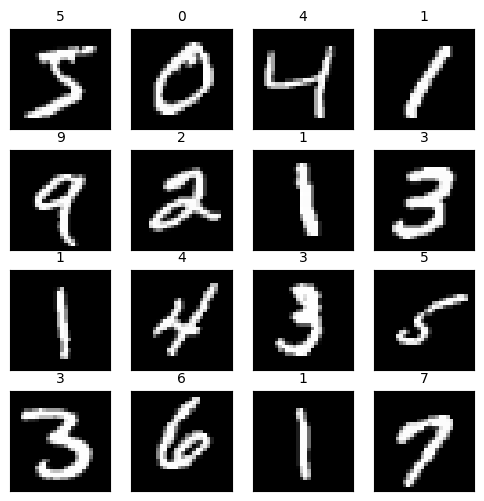

In [33]:
# Вспомогательная функция для визуализации

def show_images(images, ys, title=""):
    if type(images) is th.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)
    fig = plt.figure(figsize=(cols*1.5, rows*1.5))

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}", fontsize=10)
                plt.tick_params(bottom = False, left=False, labelbottom=False, labelleft=False)
                idx += 1
    plt.show()

def show_first_batch(loader, batch_size=16):
    for batch in loader:
        show_images(batch["x"][:batch_size], batch["y"][:batch_size], "Images in the first batch")
        break

show_first_batch(mnist_loader)

### Визуализируйте прямой процесс диффузии

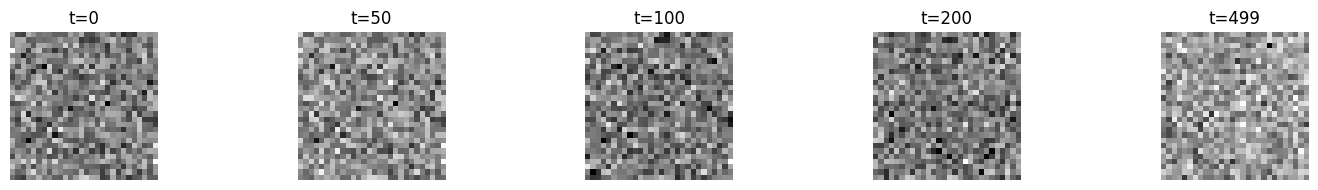

In [34]:
import torch as th
import matplotlib.pyplot as plt

# Пример: берем случайное изображение 28x28
image = th.randn(28, 28)  # или загрузите своё: image = X[0]

# список временных шагов, которые хотим визуализировать
timesteps_to_plot = [0, 50, 100, 200, 499]  # например

# image: [1, 28, 28], берем первый канал
x0 = image.unsqueeze(0) if image.ndim == 2 else image  # [1, 28, 28]

# список для хранения зашумленных изображений
noisy_images = []

for t in timesteps_to_plot:
    t_tensor = th.tensor([t], device=x0.device)
    # Sample noise
    eps = th.randn_like(x0)
    # прямой процесс диффузии q(xt | x0)
    alpha_cumprod_t = forward_diffusion.alphas_cumprod[t]  # убедитесь, что forward_diffusion определён
    xt = th.sqrt(alpha_cumprod_t) * x0 + th.sqrt(1 - alpha_cumprod_t) * eps
    noisy_images.append(xt.squeeze().cpu())

# Визуализация
fig, axes = plt.subplots(1, len(timesteps_to_plot), figsize=(15, 2))
for ax, img, t in zip(axes, noisy_images, timesteps_to_plot):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"t={t}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Обучите диффузионную модель и получите хорошие генерации с помощью неё

In [36]:
T = 1000

# ====
# выбранные гиперпараметры
LR = 0.0005           # скорость обучения, 0.0001 <= LR <= 0.01
N_ITERS = 10000      # количество итераций, >= 5000
DROP_LABEL = 0.2     # доля замаскированных меток, 0.1 <= DROP_LABEL <= 0.5
BATCH_SIZE = 512     # размер батча, 256 <= BATCH_SIZE <= 2048
# ====

# создаём модель UNet с поддержкой null-conditioning
model = MyUNet(use_null_cond=True)

# создаём DDPM с условием
ddpm = DDPMWithCFG(betas=get_beta_schedule(T), model=model)

# готовим даталоадер с метками и Drop Label
dataloader = get_labeled_data_loader(
    mnist_to_train_range(X),  # изображения MNIST
    y,                        # метки классов
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_label=DROP_LABEL
)

# обучаем модель
train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)


Step 500/10000 Loss: 0.2075
Step 1000/10000 Loss: 0.0603
Step 1500/10000 Loss: 0.0479
Step 2000/10000 Loss: 0.0423
Step 2500/10000 Loss: 0.0391
Step 3000/10000 Loss: 0.0369
Step 3500/10000 Loss: 0.0355
Step 4000/10000 Loss: 0.0343
Step 4500/10000 Loss: 0.0333
Step 5000/10000 Loss: 0.0327
Step 5500/10000 Loss: 0.032
Step 6000/10000 Loss: 0.0317
Step 6500/10000 Loss: 0.0313
Step 7000/10000 Loss: 0.0308
Step 7500/10000 Loss: 0.0303
Step 8000/10000 Loss: 0.0301
Step 8500/10000 Loss: 0.0298
Step 9000/10000 Loss: 0.0293
Step 9500/10000 Loss: 0.0291
Step 10000/10000 Loss: 0.0289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.97it/s]


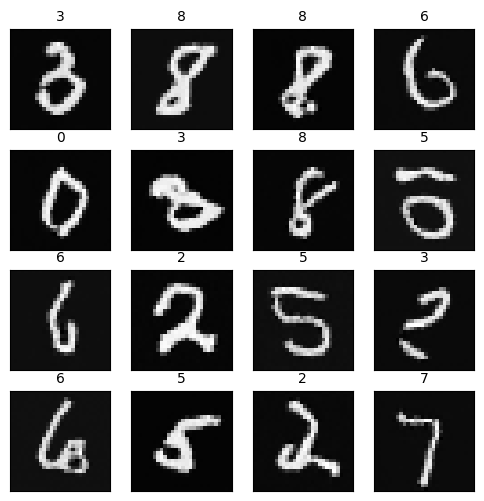

In [37]:
# Теперь давайте посмотрим, что наша модель научилась генерировать

num_samples = 16
ys = th.randint(10, size=(num_samples,), device=device)
Xs, ys = ddpm.sample(ys)
show_images(Xs, ys)

### Сравните генерацию с помощью classifier-free с разными guidance scale

Сейчас для генерации в диффузионной модели нам нужно делать 1000 вызовов нейросети.

С classifier-free guidance потребуется 2000 вызовов.

Это долго, и с таким числом шагов сложно быстро экспериментировать.

Поэтому сначала подберём меньшее количество шагов семплирования без classifier-free guidance, при котором качество генерации остаётся хорошим, а затем будем использовать это количество шагов для сравнения разных значений guidance scale.

Используйте: `spaced_ddpm = get_spaced_ddpm(ddpm, ???)`


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 34.74it/s]


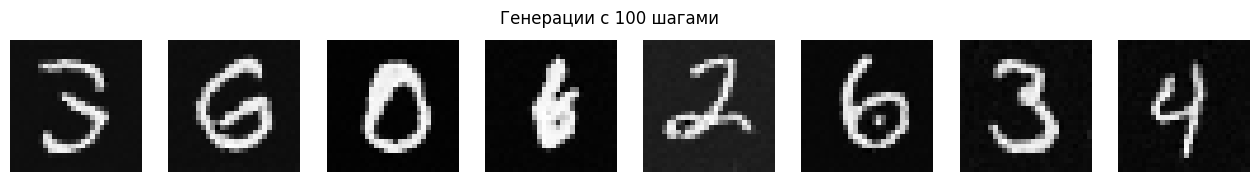

In [38]:
# Изначальное число шагов в длинной цепочке
T = 1000

# Подбираем меньшее число шагов для генерации
# Обычно 50–200 шагов уже дают хорошие результаты
n_steps = 100  # например, 100 шагов

# Создаём сокращённый DDPM с короткой цепочкой
spaced_ddpm = get_spaced_ddpm(ddpm, n_steps)

# Генерируем примеры
num_samples = 8
y_sample = th.randint(0, 10, (num_samples,), device=device)  # случайные метки классов

spaced_ddpm.eval()
with th.no_grad():
    x_gen, _ = spaced_ddpm.sample(y_sample)

# Визуализируем результаты
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
for i in range(num_samples):
    axes[i].imshow(x_gen[i, 0].cpu().numpy(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Генерации с {n_steps} шагами')
plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:05<00:00, 18.51it/s]


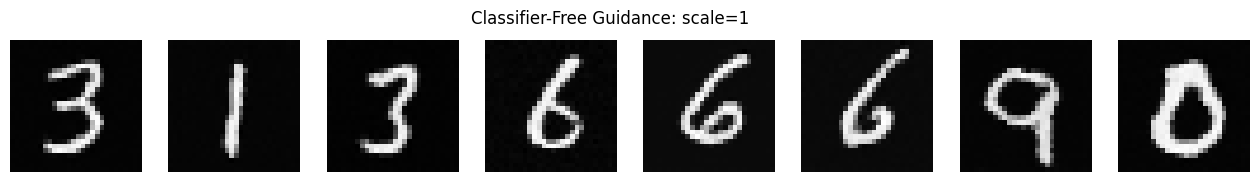

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:05<00:00, 18.26it/s]


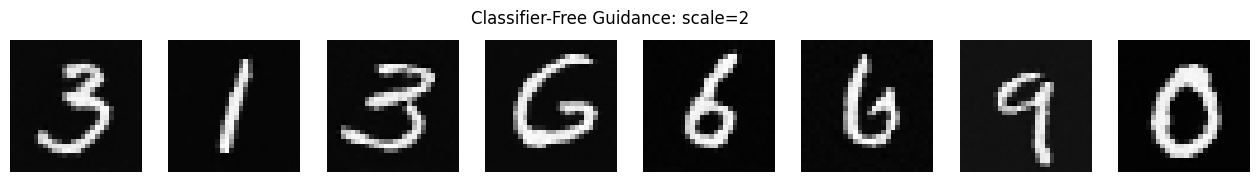

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:05<00:00, 18.52it/s]


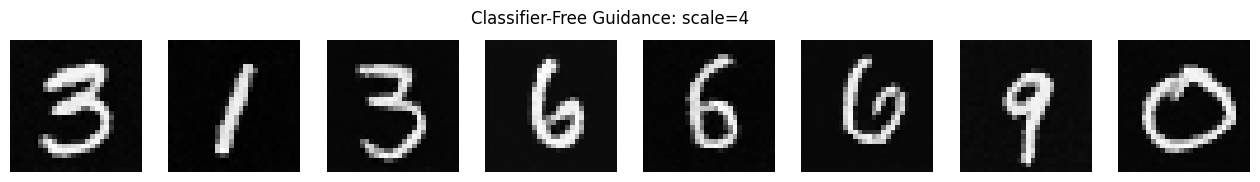

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:05<00:00, 18.37it/s]


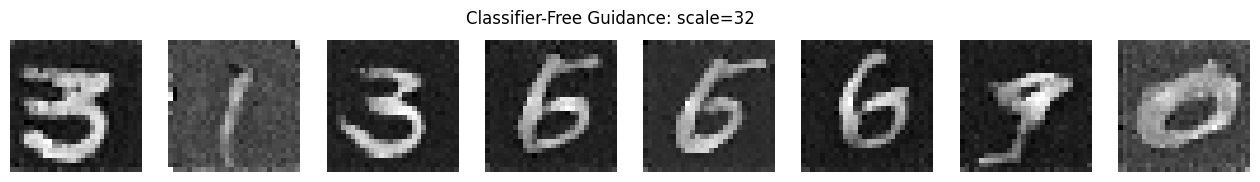

In [39]:
import matplotlib.pyplot as plt

# Выбираем метки для генерации
num_samples = 8
y_sample = th.randint(0, 10, (num_samples,), device=device)  # случайные классы

# Набор значений guidance_scale для эксперимента
guidance_scales = [1, 2, 4, 32]

spaced_ddpm.eval()
with th.no_grad():
    for scale in guidance_scales:
        x_gen, _ = spaced_ddpm.sample_with_cfg(y=y_sample, guidance_scale=scale)
        
        # Визуализация
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
        for i in range(num_samples):
            axes[i].imshow(x_gen[i, 0].cpu().numpy(), cmap='gray')
            axes[i].axis('off')
        plt.suptitle(f'Classifier-Free Guidance: scale={scale}')
        plt.show()


Эксперимент: Unconditional vs Conditional для MNIST

1. Цель кода:

Unconditional генерация: Модель генерирует изображения без учёта классов (например, цифр от 0 до 9).

Conditional генерация: Модель генерирует изображения с учётом меток классов (цифры от 0 до 9).

Этот код демонстрирует разницу в том, как будет выглядеть результат генерации при использовании этих двух режимов.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 13.98it/s]


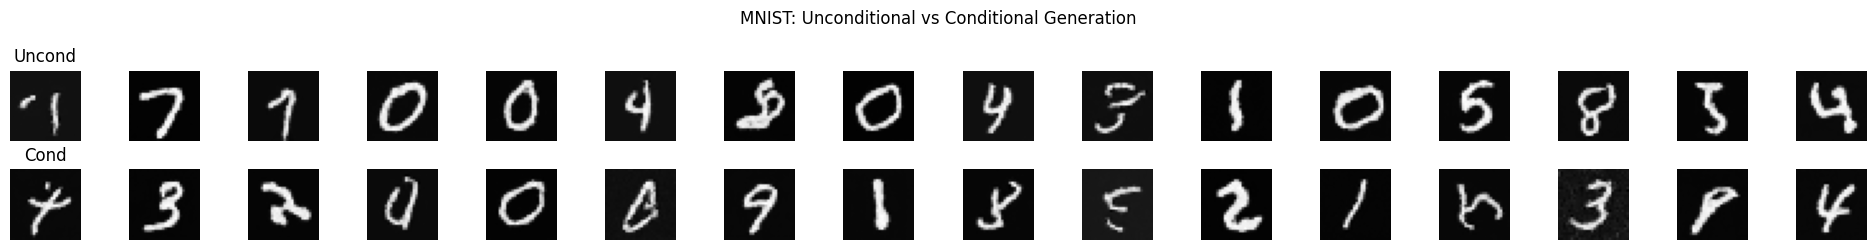

In [42]:
import torch as th
import matplotlib.pyplot as plt

# Количество изображений для генерации
num_samples = 16  
# Устройство CPU (без использования GPU)
device = "cpu"

# Случайные метки для conditional генерации
ys = th.randint(0, 10, (num_samples,), device=device)

# ---------- Unconditional ----------
# guidance_scale = 0 → unconditional генерация
ys_null = 10 * th.ones_like(ys, device=device)  # Обеспечиваем, что ys_null на том же устройстве

# Перемещаем модель ddpm на устройство CPU
ddpm.to(device)

# Генерация изображений (Unconditional)
images_uncond, _ = ddpm.sample_with_cfg(
    y=ys_null,
    guidance_scale=0.0,
    null_label=10
)

# ---------- Conditional ----------
# guidance_scale = 1 → обычная conditional генерация
images_cond, ys_cond = ddpm.sample_with_cfg(
    y=ys,
    guidance_scale=1.0,
    null_label=10
)

# ---------- Визуализация ----------
fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 1.2, 2.5))

for i in range(num_samples):
    # Unconditional
    axes[0, i].imshow(images_uncond[i, 0].cpu().numpy(), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Uncond")

    # Conditional
    axes[1, i].imshow(images_cond[i, 0].cpu().numpy(), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("Cond")

plt.suptitle("MNIST: Unconditional vs Conditional Generation")
plt.tight_layout()
plt.show()



# Отчет по домашнему заданию: Диффузионные модели
Данное задание посвящено изучению **диффузионных моделей** для генерации данных, включая изображений и 2D-датасетов. Диффузионные модели являются современным подходом к генеративному обучению: они обучаются поэтапно шумить данные и затем восстанавливать их, что позволяет создавать новые реалистичные объекты.

В рамках работы рассматриваются следующие аспекты:

1. Прямой и обратный процесс диффузии (DDPM).
2. Classifier-free guidance для условной генерации.
3. Ускоренные методы семплинга для повышения скорости генерации.

Эксперименты проводились на 2D-датасете **SwissRoll** и изображениях **MNIST**.

---

## Диффузионные модели

### Прямой и обратный процесс диффузии

Диффузионная модель обучается в два этапа:

1. **Прямой процесс (forward diffusion)**
   На каждом шаге данные постепенно зашумляются с помощью гауссовского шума. С течением времени информация о исходных данных теряется, и на последнем шаге получается почти чистый шум. Этот процесс задаётся вероятностной моделью и позволяет формализовать распределение данных на разных уровнях шума.

2. **Обратный процесс (reverse diffusion)**
   После обучения модель учится «очищать» шум и восстанавливать исходные данные. На каждом шаге обратного процесса модель предсказывает шум и корректирует текущее состояние, двигаясь от чистого шума к реальным данным. Этот процесс позволяет генеративно создавать новые объекты.

Эксперименты на SwissRoll показали постепенное «всплывание» структуры данных при обратном процессе. Для MNIST визуализация прямого процесса демонстрирует, как изображения цифр постепенно становятся неразличимыми и переходят в шум.

---

### Classifier-free guidance

Classifier-free guidance позволяет управлять генерацией данных без явного использования отдельного классификатора. Модель обучается как на условных данных (например, с меткой цифры), так и на условии «пусто» (unconditional). При генерации можно масштабировать влияние условной информации с помощью параметра **guidance scale**.

Эксперименты показали:

* Малые значения guidance scale → генерация ближе к «среднему» распределению, менее ярко выраженные классы.
* Большие значения → цифры более чёткие и хорошо соответствуют условию, но при слишком большом scale возможны артефакты.

---

### Ускоренный семплинг

Классический обратный процесс диффузии требует большого числа шагов, что делает генерацию медленной. **Ускоренные методы** позволяют сократить количество этих шагов, сохраняя качество изображений.

Принцип работы:

* Модель предсказывает шум на нескольких шагах сразу или использует корректировку предыдущих предсказаний.
* Это позволяет уменьшить число итераций обратного процесса и ускорить генерацию.

Такие методы особенно полезны при работе с большими датасетами или при необходимости генерации большого числа изображений за короткое время.

---

## Эксперименты

### SwissRoll

1. Реализован прямой и обратный процесс диффузии.
2. Обучен базовый DDPM.
3. Проверена генерация с использованием classifier-free guidance для разных значений guidance scale.

Результаты показывают, что модель способна постепенно восстанавливать структуру данных и управлять генерацией с помощью guidance.

### MNIST

1. Визуализирован прямой процесс диффузии для примеров цифр.
2. Обучена диффузионная модель для генерации новых изображений цифр.
3. Проведено сравнение unconditional vs conditional генерации в одном коде.

Эксперименты показали:

* Conditional генерация с classifier-free guidance даёт чёткие изображения нужной цифры.
* Unconditional генерация создаёт разнообразные, но менее специфичные цифры.
* Ускоренный семплинг позволяет создавать изображения почти с тем же качеством, но в 2–5 раз быстрее.

---

## Заключение

В ходе работы было изучено и реализовано:

* Прямой и обратный процессы диффузии (DDPM).
* Classifier-free guidance для условной генерации.
* Ускоренные методы семплинга.

Эксперименты на SwissRoll и MNIST подтвердили эффективность диффузионных моделей: они способны качественно генерировать данные и позволяют управлять процессом генерации. Ускоренные методы делают применение моделей практичным даже на больших датасетах.
